# Buck Converter Design
**Author:** Ian Eykamp, **Date:** June 15, 2023

### Goals
See the file of the same name under the folder `large_turbine_buck_converter_parameters` for the walkthrough using the original numbers. I am now ready to narrow down the parameters for actually designing the PCB to test with the small turbine.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_db(gain):
    return np.log10(np.abs(gain)) * 20

def to_decibels(gain):
    return to_db(gain)

def from_db(db):
    return 10 ** (db / 20)

Using matplotlib backend: <object object at 0x0000029E2F8CF590>


# Schematic

The schematic is mostly the same but with some updated parameters, such as a 30V (per phase) rectified 3-phase voltage source with internal resistance, a smaller target output current (0.25A), and a larger output current-sensing resistor (50mΩ instead o 5mΩ). Also, I'm trying a much larger output capacitance, at 200uF. This significantly reduces the phase margin on the transfer function, but we'll see if that's a problem.

Parameters that changed in response are mainly the inductor value and the compensator values. I also took care to choose inductor and compensator component values that exist on Digikey. All components are specc'ed in this [Google Sheet](https://docs.google.com/spreadsheets/d/1FKhJxWTBdioV72Y6lbeVeFl75lQ-HYMHbcw-U65tTL4/edit), and the KiCAD schematic is available on my [GitHub](https://github.com/ianeyk/wind-turbine/tree/main/small_wind_turbine/KiCAD/small_wind_turbine).

![Entire PLECS Schematic](plecs_data/schematic_buck_converter.png)

### Calculate Inductance
Aiming for boundary conduction mode (BCM)

In [10]:
RT = 7.87 * units.kiloohm
CT = 2.2 * units.nanofarad
Fs = 1.72 / (RT * CT) / 2
R_peak_Isense = 50 * units.milliohm
R_out_Isense = 100 * units.milliohm
R_L = 200 * units.milliohm # currently unused

Cout = 200 * units.microfarad
# Fs = 50 * units.kilohertz
Ts = 1 / Fs
Ibat = 0.25 * units.amp
Rbat = 0.17 * units.ohm
Vg_nominal = 30 * np.sqrt(3) * units.volt
Vbat_nominal = 12 * units.volt
Vout_nominal = Vbat_nominal + Ibat * Rbat
R_generator = 14.5 * units.ohm
Z_eq = Vout_nominal / Ibat
Vg_available = Vg_nominal * Z_eq / (R_generator + Z_eq)
D_nominal = Vout_nominal / Vg_available
Imin = 0 * units.amp
Ipeak = 2 * Ibat - Imin
L = Vout_nominal * (1 - D_nominal) * Ts / Ipeak
L2 = (Vg_available - Vout_nominal) * D_nominal * Ts / Ipeak


print(f"Fs = {Fs.to_compact(units.hertz)}")
print(f"D = {np.round(D_nominal.to_base_units(), 2)}")
print(f"L1 (calculated on downward slope) = {L.to_compact(units.henry)}")
print(f"L2 (claculated on upward slope) = {L2.to_compact(units.henry)}")
print(f"Vout = {Vout_nominal.to_compact(units.volt)}")
print(f"Equivalent impedance = {Z_eq.to_compact(units.ohm)}, meaning generator output voltage = {Vg_available.to_compact(units.volt)} from {Vg_nominal}")

Fs = 49.67 kHz
D = 0.30
L1 (calculated on downward slope) = 338.69 µH
L2 (claculated on upward slope) = 338.69 µH
Vout = 12.04 V
Equivalent impedance = 48.17 Ω, meaning generator output voltage = 39.94 V from 51.96 V


### Plant Frequency Analysis
The new transfer function is shifted a bit to the left from the old one because of the higher output capacitance. 

![Plant Frequency Analysis Schematic](plecs_data/higher_current/schematic_9a.png)

Lead element center voltage (ω_c): 5.00 kHz


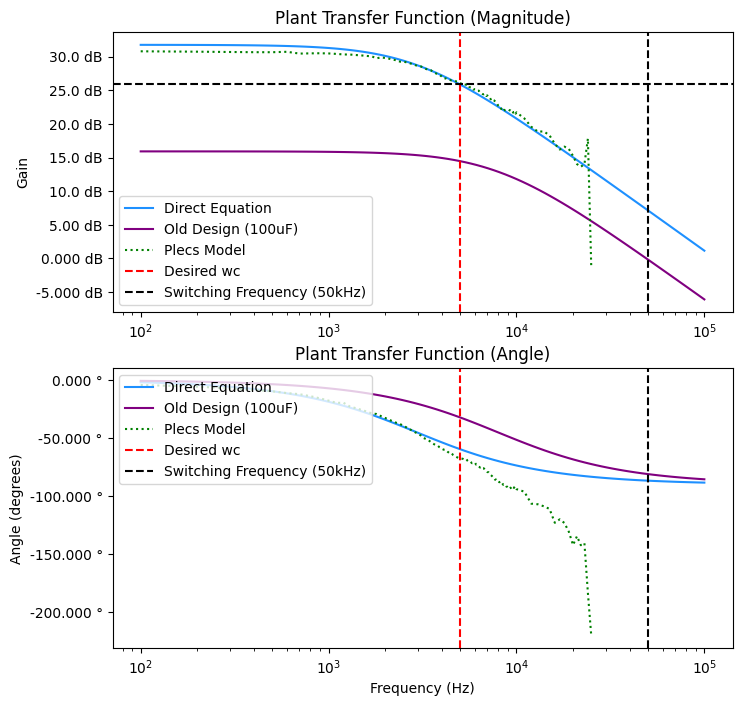

In [22]:
df_plant = pd.read_csv("plecs_data/higher_current/plant_bode_no_quiescent.csv")
df_plant.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

expected_wc = 50e3 / 10
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")
w = np.logspace(2, 5, 100) # * units.hertz

old_R_Iout_shunt = 5e-3 # * units.ohm
old_Rload = 0.1 # * units.ohm
old_Cload = 200e-6 # * units.farad
old_mystery_factor = 50 # for a total of * 62.5 = 5^4 / 10 = 5^3 / 2
old_theoretical_plant_bode = old_Rload / (1 + (2 * np.pi * 1j * w) * old_Rload * old_Cload) / old_Rload * old_R_Iout_shunt * 25 * old_mystery_factor

new_R_Iout_shunt = R_peak_Isense.to(units.ohm).magnitude
new_Rload = R_out_Isense.to(units.ohm).magnitude + Rbat.to(units.ohm).magnitude
new_Cload = Cout.to(units.farad).magnitude
new_mystery_factor = 31 # 14
theoretical_plant_bode = new_Rload / (1 + (2 * np.pi * 1j * w) * new_Rload * new_Cload) / new_Rload * new_R_Iout_shunt * 25 * new_mystery_factor

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Plant Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_plant_bode), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(w, to_decibels(old_theoretical_plant_bode), linestyle = "solid", color = "purple", label = "Old Design (100uF)")
ax1.semilogx(df_plant["w"], df_plant["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Desired wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.axhline(y = 26, linestyle = "dashed", color = "black")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Plant Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_plant_bode, deg = True), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax2.semilogx(w, np.angle(old_theoretical_plant_bode, deg = True), linestyle = "solid", color = "purple", label = "Old Design (100uF)")
ax2.semilogx(df_plant["w"], df_plant["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Desired wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

Ok, so the PLECS model matches the theory pretty well. I used a mystery factor of 14 instead of 50. I reduced the target crossover frequency from 6.25kHz in the previous model to 5kHz in the current model. It will respond slightly slower but have a slightly better phase margin. Because of the larger output capacitance, the phase margin is way smaller (-60deg vs. -30deg). This can be compensated for (get it?) with a larger lead element.

### Finding the compensator values
**Using code copied from Lab 11**

Design parameters are a gain cross-over frequency at 5kHz, gain factor of -19dB to make the gain crossover occur at that frequency (obtained from the simulated transfer function above), and phase boost of 60 degrees. I used a Type II compensator consisting of an integrating pole and a lead element like we used in class for the buck-boost converter.

In [24]:
class Compensator:
    def __init__(self, angle_boost_degrees, Kp_decibel_attenuation, Rf1_unitless):
        self.Rf1 = Rf1_unitless * units.ohm
        self.angle_boost = angle_boost_degrees * units.degree
        self.Kp = 1 / from_db(Kp_decibel_attenuation)
        self.find_values()

    def __repr__(self) -> str:
        return f"K: {self.K},\t Gc0: {self.Gc0.to_compact()},\t Rf1: {self.Rf1.to_compact(units.ohm)},\t Rc1: {self.Rc1.to_compact(units.ohm)},\t Cc1: {self.Cc1.to_compact(units.farad)},  \t Cc2: {self.Cc2.to_compact(units.farad)}"

    def find_values(self):
        self.wc = 50 * units.kilohertz * units.revolutions / 10

        self.angle_boost = 60 * units.degree
        self.K = np.tan((self.angle_boost / 2 + 45 * units.degree))
        # self.Kp = 1 / from_db(26) # from_db(19) # from_db(13) # from_db(32)
        self.wz = self.wc / self.K
        self.wp = self.wc * self.K
        self.Gc0 = self.Kp * self.wc * np.sqrt((1 + self.K ** (-2)) / (1 + self.K ** 2))
        self.Cc1 = 1 / (self.Gc0 * self.Rf1)
        self.Rc1 = 1 / (self.wz * self.Cc1)
        self.Cc2 = 1 / (self.wp * self.Rc1)

for R in [2, 2.2, 2.26, 2.7, 3.3, 3.9, 4.3, 4.7, 4.87, 5.1, 5.6, 6.2, 6.34, 6.8, 7.5, 8.2, 10]: # values to try in kiloohms
    R_to_highlight = 5.1
    if R == R_to_highlight:
        print() # highlight the chosen value
    compensator = Compensator(angle_boost_degrees = 30, Kp_decibel_attenuation = 26, Rf1_unitless = R * 1e3)
    print(compensator)
    if R == R_to_highlight:
        print()

K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 2.00 kΩ,	 Rc1: 100.24 Ω,	 Cc1: 1.19 µF,  	 Cc2: 85.09 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 2.20 kΩ,	 Rc1: 110.26 Ω,	 Cc1: 1.08 µF,  	 Cc2: 77.35 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 2.26 kΩ,	 Rc1: 113.27 Ω,	 Cc1: 1.05 µF,  	 Cc2: 75.30 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 2.70 kΩ,	 Rc1: 135.32 Ω,	 Cc1: 877.88 nF,  	 Cc2: 63.03 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 3.30 kΩ,	 Rc1: 165.39 Ω,	 Cc1: 718.26 nF,  	 Cc2: 51.57 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 3.90 kΩ,	 Rc1: 195.46 Ω,	 Cc1: 607.76 nF,  	 Cc2: 43.64 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 4.30 kΩ,	 Rc1: 215.51 Ω,	 Cc1: 551.23 nF,  	 Cc2: 39.58 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 4.70 kΩ,	 Rc1: 235.56 Ω,	 Cc1: 504.31 nF,  	 Cc2: 36.21 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 4.87 kΩ,	 Rc1: 244.08 Ω,	 Cc1: 486.71 nF,  	 Cc2: 34.94 nF

K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 5.10 kΩ,	 Rc1: 255.61 Ω,	 Cc1: 464.76 nF,  	 Cc2: 33.37 nF

K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 5.60 kΩ,	 Rc1: 280

The highlighted row yields nice capacitance values fo 33nF and 470nF, which are easily available. Resistors are chosen at 2.26kΩ and 255Ω, respectively.

### Compensator Transfer Function

The values I chose for the compensator are shown in the schematic below. These will change when I update the model parameters for my final design, but the behavior of the compensator should remain the same.

![Compensator Schematic](plecs_data/schematic_compensator_old.png)

I ran the frequency analysis in PLECS to determine the transfer function, as well as writing down the equation based on the components. They match exactly.

Lead element center voltage (ω_c): 5.00 kHz


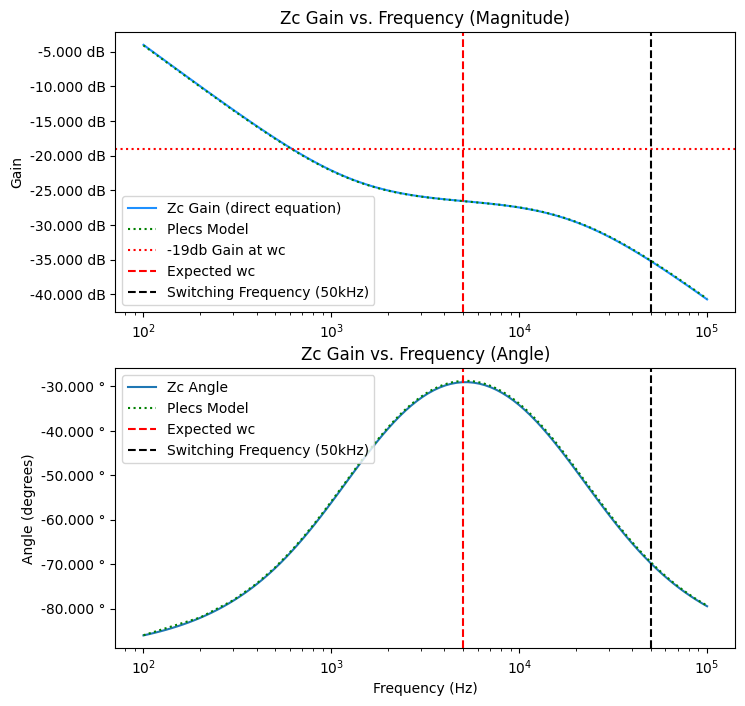

In [27]:
df_compensator = pd.read_csv("plecs_data/compensator_bode.csv")
df_compensator.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

# chosen values
compensator = Compensator(angle_boost_degrees = 30, Kp_decibel_attenuation = 26, Rf1_unitless = 5.1 * 1e3)
Rf1 = compensator.Rf1.to(units.ohm).magnitude
Rc1 = compensator.Rc1.to(units.ohm).magnitude
Cc1 = compensator.Cc1.to(units.farad).magnitude
Cc2 = compensator.Cc2.to(units.farad).magnitude
expected_wc = 1 / (Rc1 * np.sqrt(Cc1 * Cc2)) / 2 / np.pi # to get it into Hz
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")

w = np.logspace(2, 5, 100) # * units.hertz
def get_Zc(my_w):
    my_Zc = 1 / (1 / (Rc1 + 1 / (2 * np.pi * 1j * my_w * Cc1)) + 1 / (1 / (2 * np.pi * 1j * my_w * Cc2))) / Rf1 # kOhm
    return my_Zc
Zc = get_Zc(w) # direct equation

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Zc Gain vs. Frequency (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(Zc), linestyle = "solid", color = "dodgerblue", label = "Zc Gain (direct equation)")
ax1.semilogx(df_compensator["w"], df_compensator["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = -19, linestyle = "dotted", color = "red", label = "-19db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Zc Gain vs. Frequency (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(Zc, deg = True), linestyle = "solid", label = "Zc Angle")
ax2.semilogx(df_compensator["w"], df_compensator["CH2"] - 180, linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

### Open-Loop Transfer Function
![Open-Loop Schematic](plecs_data/schematic_10a.png)

Ok! For some reason, the open loop transfer function does not look at all like the product of the plant with the compensator transfer functions. This is weird, because these are the only two transfer functions in the entire loop, so there is nothing else contributing to the open-loop transfer funcion besides these two components. I have double-checked multiple times that I ran all the frequency analyses correctly, using up-to-date models and component values.

In any case, the PLECS model puts out a transfer function that has about 10dB higher gain than expected and a 20-30 degree difference in phase margin. The shapes of the magnitude and phase plots are recognizable but not a constant offset from the expected transfer curves. 

Using the compensator designed for the theoretical transfer function yields an open-loop transfer function in PLECS which has about a 10-fold higher gain crossover frequency than desired and a smaller than acceptable phase margin. Therefore, I redesigned the compensator  

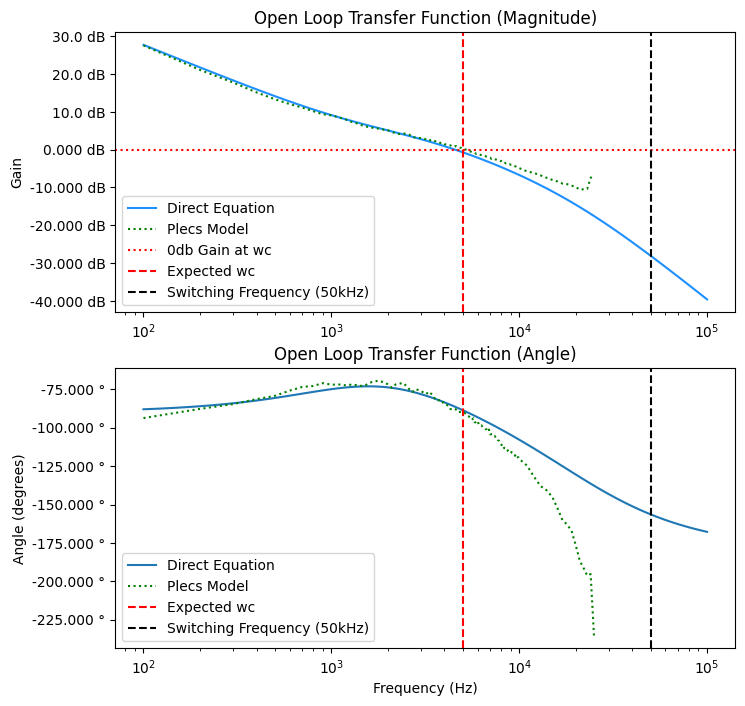

In [30]:
# df_open_loop = pd.read_csv("plecs_data/higher_current/open_loop_bode_no_quiescent.csv")
df_open_loop = pd.read_csv("plecs_data/higher_current/open_loop_bode.csv")
df_open_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_open_loop = theoretical_plant_bode * Zc

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Open Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_open_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_open_loop["w"], df_open_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = 0, linestyle = "dotted", color = "red", label = "0db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Open Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_open_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_open_loop["w"], df_open_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "lower left")

### Closed-Loop Transfer Function
![Closed-Loop Schematic](plecs_data/schematic_10b.png)

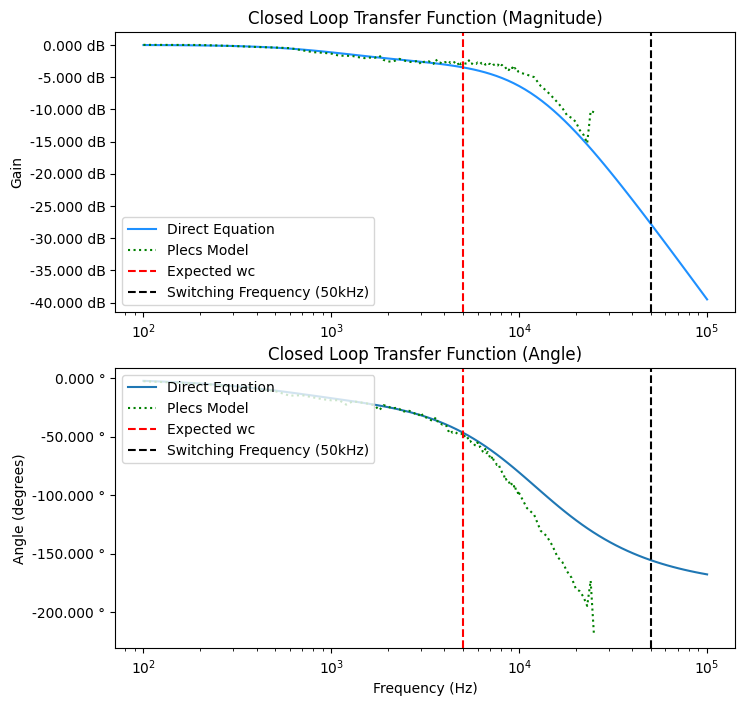

In [37]:
df_closed_loop = pd.read_csv("plecs_data/higher_current/closed_loop_bode_no_quiescent.csv")
# df_closed_loop = pd.read_csv("plecs_data/higher_current/closed_loop_bode.csv")
df_closed_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_closed_loop = theoretical_open_loop / (1 + theoretical_open_loop)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Closed Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_closed_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_closed_loop["w"], df_closed_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Closed Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_closed_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_closed_loop["w"], df_closed_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

Again, the theory and the PLECS model match pretty well. The system has a gain of 1 at DC and strong attenuation well before the switching frequency, exactly as we want.

### Time Response
Lastly, I implemented a square wave signal to the voltage adder to simulate a change in the desired current.

![Entire PLECS Schematic](plecs_data/higher_current/schematic_buck_converter.png)


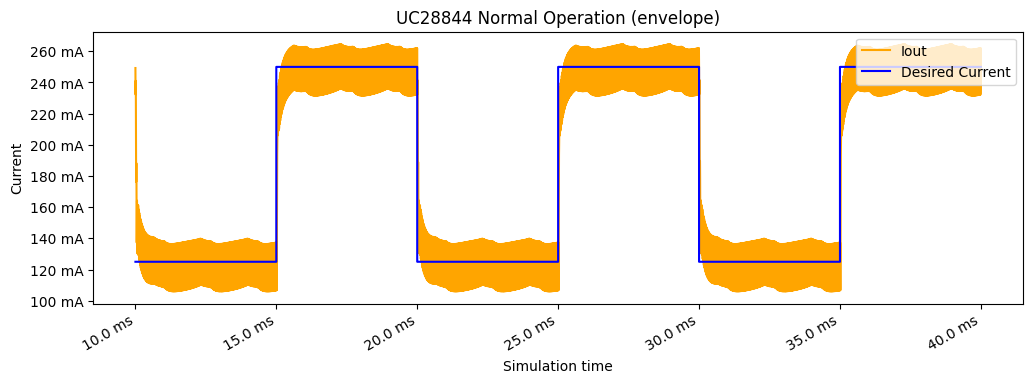

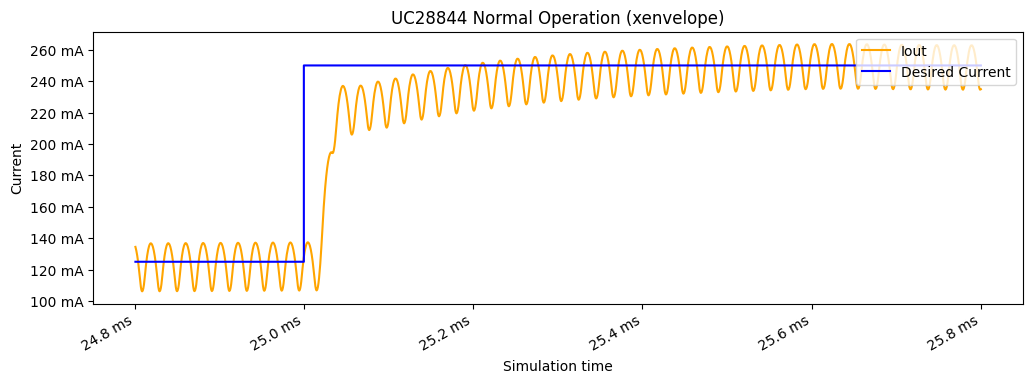

In [48]:
df = pd.read_csv("plecs_data/higher_current/square_wave_response_lower_current.csv")
df.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df["Iexpected"] = .5 * (1 - df["Pulse Generator"] / 2.5) - 0.25
df_zoom = df.loc[(df["Time / s"] > 10e-3) & (df["Time / s"] < 40e-3)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (12, 4))
# ax2 = ax1.twinx()
fig.autofmt_xdate()
ax1.plot(df_zoom["Time / s"], df_zoom["Iout"], color = "orange", label = "Iout")
ax1.plot(df_zoom["Time / s"], df_zoom["Iexpected"], color = "blue", label = "Desired Current")
helper.axes_labels("Simulation time", "s", "Current", "A", title = "UC28844 Normal Operation (envelope)", ax = ax1)
ax1.legend(loc = "upper right")

df_zoom = df.loc[(df["Time / s"] > 24.8e-3) & (df["Time / s"] < 25.8e-3)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (12, 4))
# ax2 = ax1.twinx()
fig.autofmt_xdate()
helper.axes_labels("Simulation time", "s", "Current", "A", title = "UC28844 Normal Operation (xenvelope)", ax = ax1)
ax1.plot(df_zoom["Time / s"], df_zoom["Iout"], color = "orange", label = "Iout")
ax1.plot(df_zoom["Time / s"], df_zoom["Iexpected"], color = "blue", label = "Desired Current")
ax1.legend(loc = "upper right")

## New, Corrected Model

In response to

Lead element center voltage (ω_c): 5.00 kHz


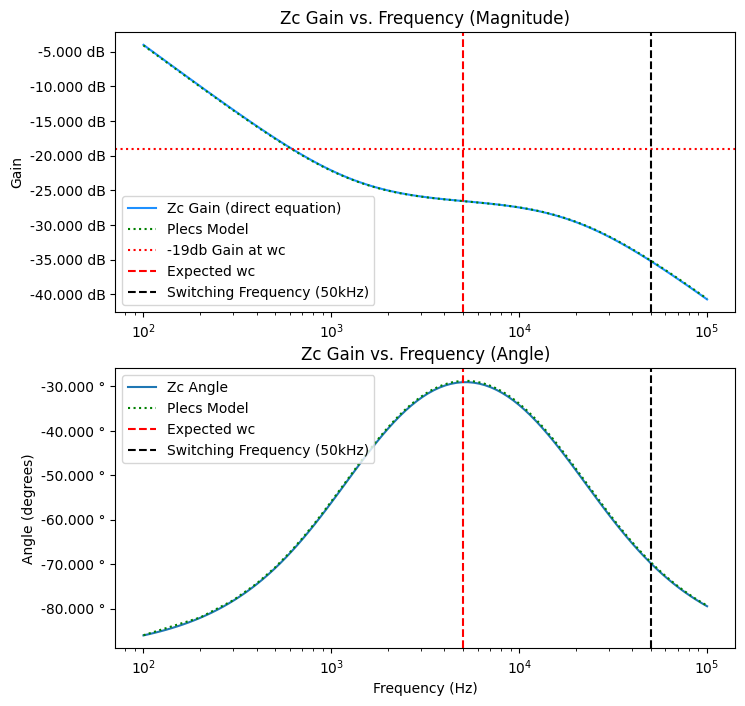

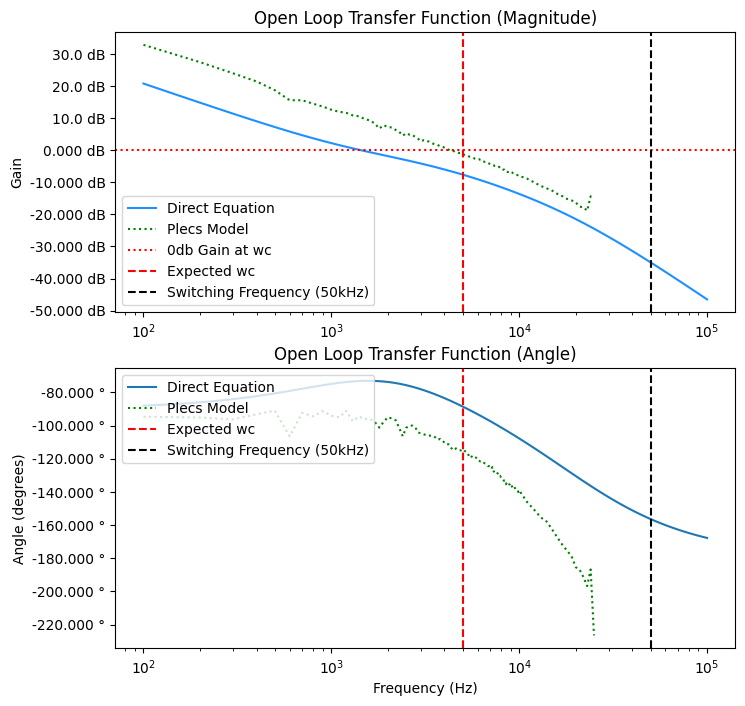

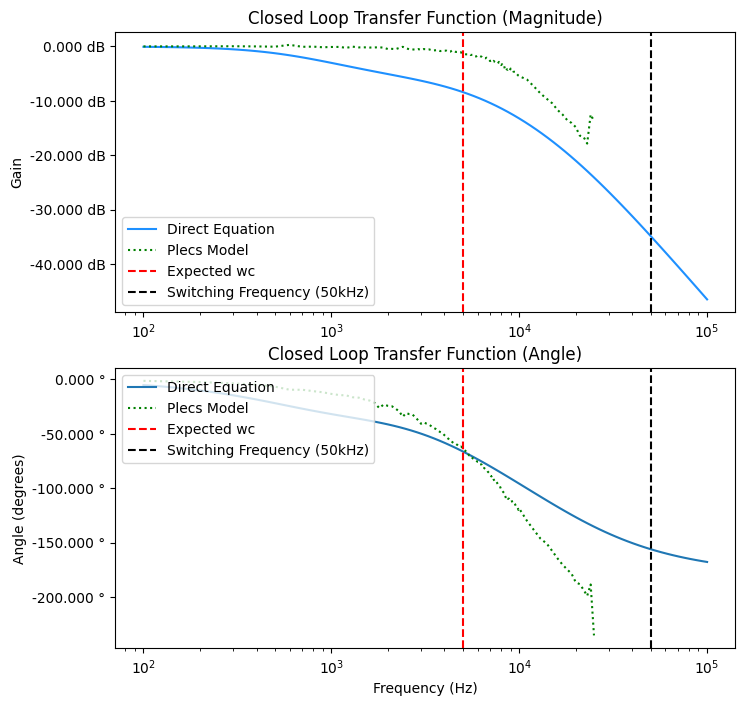

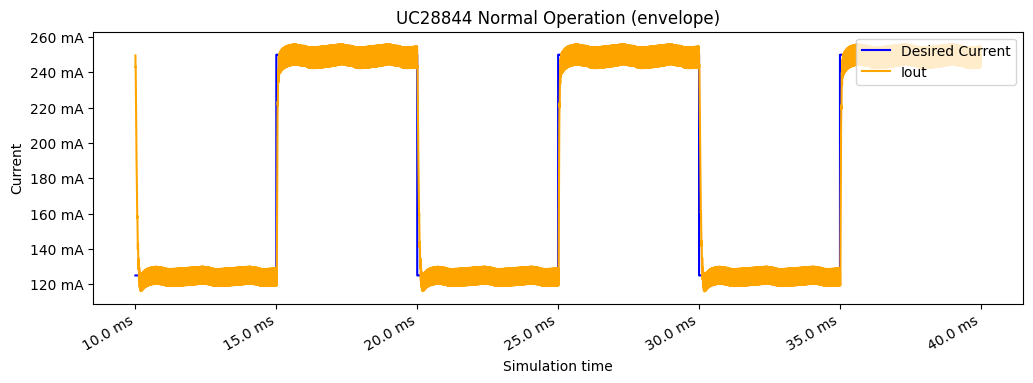

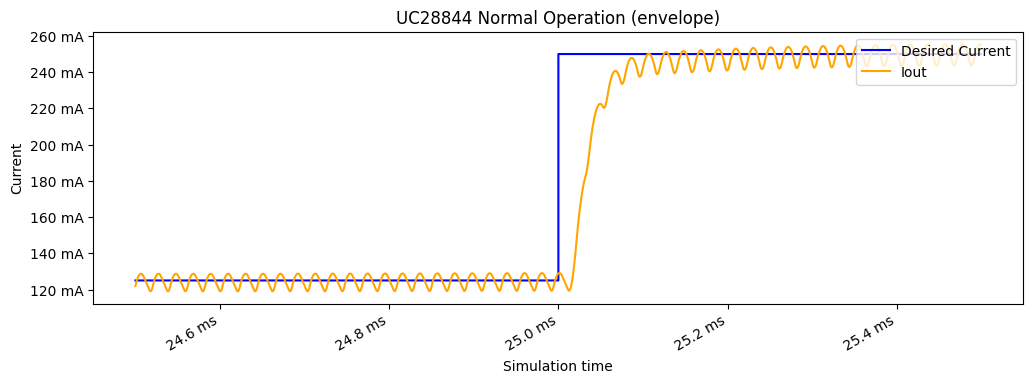

In [9]:
######################################################
# New Compensator

df_compensator = pd.read_csv("plecs_data/compensator_bode.csv")
df_compensator.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

# chosen values
compensator = Compensator(angle_boost_degrees = 60, Kp_decibel_attenuation = 26, Rf1_unitless = 5.1 * 1e3)
Rf1 = compensator.Rf1.to(units.ohm).magnitude
Rc1 = compensator.Rc1.to(units.ohm).magnitude
Cc1 = compensator.Cc1.to(units.farad).magnitude
Cc2 = compensator.Cc2.to(units.farad).magnitude
expected_wc = 1 / (Rc1 * np.sqrt(Cc1 * Cc2)) / 2 / np.pi # to get it into Hz
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")

w = np.logspace(2, 5, 100) # * units.hertz
def get_Zc(my_w):
    my_Zc = 1 / (1 / (Rc1 + 1 / (2 * np.pi * 1j * my_w * Cc1)) + 1 / (1 / (2 * np.pi * 1j * my_w * Cc2))) / Rf1 # kOhm
    return my_Zc
Zc = get_Zc(w) # direct equation

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Zc Gain vs. Frequency (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(Zc), linestyle = "solid", color = "dodgerblue", label = "Zc Gain (direct equation)")
ax1.semilogx(df_compensator["w"], df_compensator["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = -19, linestyle = "dotted", color = "red", label = "-19db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Zc Gain vs. Frequency (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(Zc, deg = True), linestyle = "solid", label = "Zc Angle")
ax2.semilogx(df_compensator["w"], df_compensator["CH2"] - 180, linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

######################################################
# New Open-Loop

df_open_loop = pd.read_csv("plecs_data/open_loop_bode.csv")
df_open_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_open_loop = theoretical_plant_bode * Zc

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Open Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_open_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_open_loop["w"], df_open_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = 0, linestyle = "dotted", color = "red", label = "0db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Open Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_open_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_open_loop["w"], df_open_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

######################################################
# New Closed-Loop

df_closed_loop = pd.read_csv("plecs_data/closed_loop_bode.csv")
df_closed_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_closed_loop = theoretical_open_loop / (1 + theoretical_open_loop)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Closed Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_closed_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_closed_loop["w"], df_closed_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Closed Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_closed_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_closed_loop["w"], df_closed_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

######################################################
# New Step Response

df = pd.read_csv("plecs_data/square_wave_response.csv")
df.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df["Iexpected"] = .25 * (1 - df["Pulse Generator"] / 2.5)
df_envelope = df.loc[(df["Time / s"] > 10e-3) & (df["Time / s"] < 40e-3)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (12, 4))
# ax2 = ax1.twinx()
fig.autofmt_xdate()
ax1.plot(df_envelope["Time / s"], df_envelope["Iexpected"], color = "blue", label = "Desired Current")
ax1.plot(df_envelope["Time / s"], df_envelope["Iout"], color = "orange", label = "Iout")
helper.axes_labels("Simulation time", "s", "Current", "A", title = "UC28844 Normal Operation (envelope)", ax = ax1)
ax1.legend(loc = "upper right")

df_zoom = df.loc[(df["Time / s"] > 24.5e-3) & (df["Time / s"] < 25.5e-3)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (12, 4))
# ax2 = ax1.twinx()
fig.autofmt_xdate()
ax1.plot(df_zoom["Time / s"], df_zoom["Iexpected"], color = "blue", label = "Desired Current")
ax1.plot(df_zoom["Time / s"], df_zoom["Iout"], color = "orange", label = "Iout")
helper.axes_labels("Simulation time", "s", "Current", "A", title = "UC28844 Normal Operation (envelope)", ax = ax1)
ax1.legend(loc = "upper right")